# imports

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image
import pandas as pd
import torchvision.transforms as transforms
import numpy as np
from sklearn.model_selection import train_test_split
import os
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from torchviz import make_dot
import pydot


# global vars

In [9]:
IMG_SHAPE = 48
NUM_CLASSES = 3
BATCH_SIZE = 1024
TEXT_COL = "text_emo"
IMAGE_COL = 'local_path'
LABEL_COL = 'label'
LABELS_PATH = "C:/Users/MourtadaHouari/Desktop/sentiment-analysis/data/processed/train_images.csv"
IMAGES_PATH_PREFIX = "C:/Users/MourtadaHouari/Desktop/sentiment-analysis/data/processed"
LR = 0.001
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(DEVICE)
torch.cuda.get_device_name(0)
SAVE_DIR = "."
EPOCHS=3

cuda:0


# functions

In [15]:
dic = {0: "negative", 1: "neutral", 2: "positive"}

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

transform = transforms.Compose([
                        transforms.Resize((IMG_SHAPE, IMG_SHAPE)),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                    ])


def train(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    for batch_idx, (image, label) in enumerate(train_loader):
        image, label = image.to(device), label.to(device)

        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        acc = accuracy(output, label)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_acc += acc.item()

    return running_loss / len(train_loader), running_acc / len(train_loader)

def predict(model, image, label=None):
    model.eval()
    with torch.no_grad():
        image = image.to(DEVICE)
        output = model(image)
        result = torch.max(output, dim=1).indices[0].cpu().item()
        print("predicted label:", dic[result])
        if label != None:
            print("actual label:", label)
    return output

def test(model, predict_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_acc = 0.0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch_idx, (image, label) in enumerate(predict_loader):
            image, label = image.to(device), label.to(device)

            output = model(image)
            loss = criterion(output, label)
            acc = accuracy(output, label)

            running_loss += loss.item()
            running_acc += acc.item()

            _, preds = torch.max(output, dim=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(label.cpu().numpy())

    avg_loss = running_loss / len(predict_loader)
    avg_acc = running_acc / len(predict_loader)

    return avg_loss, avg_acc, predictions, true_labels


def val(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_acc = 0.0
    with torch.no_grad():
        for batch_idx, (image, label) in enumerate(test_loader):
            image, label = image.to(device), label.to(device)

            output = model(image)
            loss = criterion(output, label)
            acc = accuracy(output, label)

            running_loss += loss.item()
            running_acc += acc.item()

    return running_loss / len(test_loader), running_acc / len(test_loader)

def save_model(model, save_dir, filename):
    torch.save(model.state_dict(), os.path.join(save_dir, filename))

# model

In [10]:

class ImageClassifier(nn.Module):
    def __init__(self):
        super(ImageClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5, padding=2)  # Increase filter size to 5x5
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5, padding=2)  # Increase filter size to 5x5
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)  # Keep the filter size at 3x3
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)  # Keep the filter size at 3x3
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.dropout1 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256 * IMG_SHAPE//16 * IMG_SHAPE//16, 512)
        self.relu5 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 3)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.pool4(x)
        x = self.flatten(x)
        x = self.dropout1(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc1(x)
        x = self.relu5(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

# dataset

In [13]:
class ImageDataset(Dataset):
    def __init__(self, csv_path):
        self.data = pd.read_csv(csv_path)
        self.transform = transforms.Compose([
                        transforms.Resize((IMG_SHAPE, IMG_SHAPE)),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                    ])

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image_path = self.data.loc[idx, IMAGE_COL][1:]
        image = Image.open(IMAGES_PATH_PREFIX+image_path).convert('RGB')
        image = self.transform(image)

        label = self.data.loc[idx, LABEL_COL]
        return image, label

# init model

In [9]:
data = ImageDataset(LABELS_PATH)
indices = np.arange(len(data))
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)


train_data = Subset(data, train_indices)
test_data = Subset(data, test_indices)


train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

model = ImageClassifier().to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
model


ImageClassifier(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=2304, out_features=512, bias=True)
  (relu5): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_featu

# train

In [10]:
best_val_acc = 0.0
count = 0
val_acc_list = []
train_acc_list = []
val_loss_list = []
train_loss_list = []

EPOCHS = 20
for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, DEVICE)
    val_loss, val_acc = val(model, test_loader, criterion, DEVICE)

    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    val_acc_list.append(val_acc)
    val_loss_list.append(val_loss)
    
    print(
        f"Epoch: {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
        f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
    )
    

    if val_acc > best_val_acc:
        print(f"New best model! Saving...")
        save_model(model, SAVE_DIR, "attention_best_model.pt")
        best_val_acc = val_acc
        print(f"Best val acc: {best_val_acc:.4f}")
        count = 0
    else:
        count += 1
        print(f"Count: {count} of epochs have no improvement")
        if count == 5:
            print(f"Early stopping, best val acc: {best_val_acc:.4f}")
            break


Epoch: 1/20, Train Loss: 1.0900, Train Acc: 0.4096, Val Loss: 1.0704, Val Acc: 0.4349
New best model! Saving...
Best val acc: 0.4349
Epoch: 2/20, Train Loss: 1.0762, Train Acc: 0.4247, Val Loss: 1.0564, Val Acc: 0.4617
New best model! Saving...
Best val acc: 0.4617
Epoch: 3/20, Train Loss: 1.0610, Train Acc: 0.4388, Val Loss: 1.0309, Val Acc: 0.4830
New best model! Saving...
Best val acc: 0.4830
Epoch: 4/20, Train Loss: 1.0094, Train Acc: 0.5111, Val Loss: 0.9719, Val Acc: 0.5471
New best model! Saving...
Best val acc: 0.5471
Epoch: 5/20, Train Loss: 0.9580, Train Acc: 0.5679, Val Loss: 0.9310, Val Acc: 0.6034
New best model! Saving...
Best val acc: 0.6034
Epoch: 6/20, Train Loss: 0.9307, Train Acc: 0.6000, Val Loss: 0.9208, Val Acc: 0.6064
New best model! Saving...
Best val acc: 0.6064
Epoch: 7/20, Train Loss: 0.9120, Train Acc: 0.6151, Val Loss: 0.9065, Val Acc: 0.6234
New best model! Saving...
Best val acc: 0.6234
Epoch: 8/20, Train Loss: 0.8990, Train Acc: 0.6340, Val Loss: 0.8884,

# learning rate

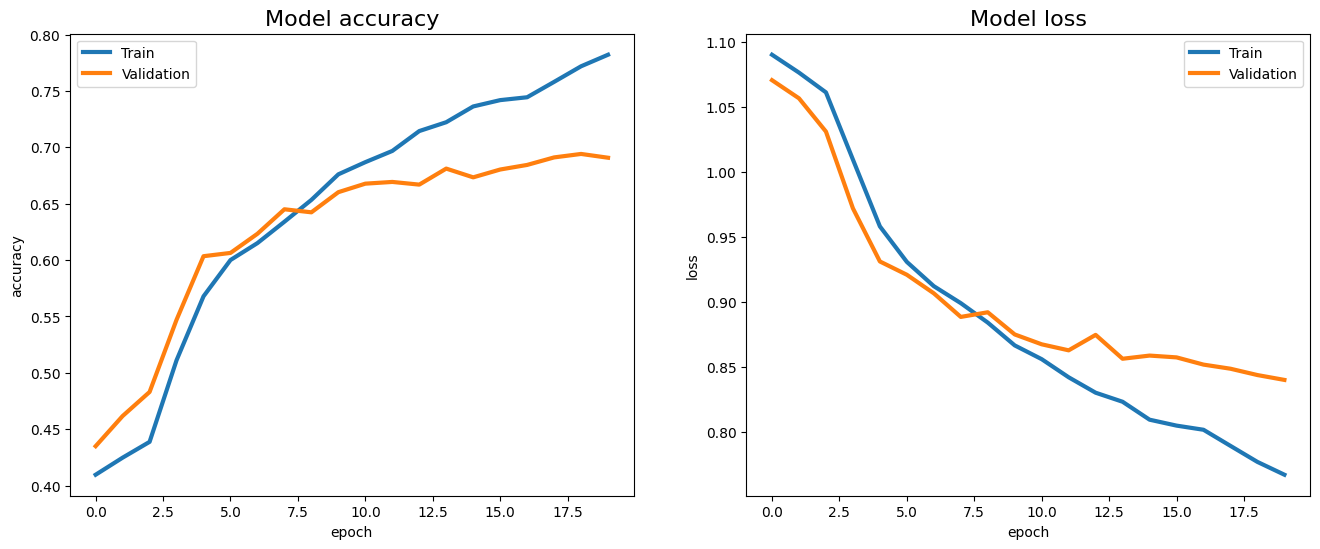

In [11]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
# summarize history for accuracy
axis1.plot(train_acc_list, label='Train', linewidth=3)
axis1.plot(val_acc_list, label='Validation', linewidth=3)
axis1.set_title('Model accuracy', fontsize=16)
axis1.set_ylabel('accuracy')
axis1.set_xlabel('epoch')
axis1.legend(loc='upper left')

axis2.plot(train_loss_list, label='Train', linewidth=3)
axis2.plot(val_loss_list, label='Validation', linewidth=3)
axis2.set_title('Model loss', fontsize=16)
axis2.set_ylabel('loss')
axis2.set_xlabel('epoch')
axis2.legend(loc='upper right')
plt.show()

# predict

In [42]:
import cv2
import torch

# Initialize the camera
camera = cv2.VideoCapture(0)

while True:
    # Read the current frame from the camera
    ret, frame = camera.read()

    # Display the frame
    cv2.imshow("Camera", frame)

    # Check if the 'c' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('c'):
        # Save the current frame as an image
        cv2.imwrite("captured_image.jpg", frame)
        print("Image captured!")

        image = Image.open("captured_image.jpg").convert('RGB')
        image = transform(image).unsqueeze(0)
        text = "its fucked"

        predict(model, image, "")



    # Check if the 'q' key is pressed to exit the loopq
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the camera and close the window
camera.release()
cv2.destroyAllWindows()


Image captured!
predicted label: neutral
actual label: 
Image captured!
predicted label: neutral
actual label: 
Image captured!
predicted label: neutral
actual label: 
Image captured!
predicted label: neutral
actual label: 
Image captured!
predicted label: neutral
actual label: 
Image captured!
predicted label: positive
actual label: 
Image captured!
predicted label: negative
actual label: 
Image captured!
predicted label: neutral
actual label: 
Image captured!
predicted label: negative
actual label: 
Image captured!
predicted label: negative
actual label: 
Image captured!
predicted label: positive
actual label: 
Image captured!
predicted label: neutral
actual label: 
Image captured!
predicted label: neutral
actual label: 
Image captured!
predicted label: neutral
actual label: 
Image captured!
predicted label: neutral
actual label: 
Image captured!
predicted label: positive
actual label: 
Image captured!
predicted label: positive
actual label: 
Image captured!
predicted label: negative

# test

Test Acc: 0.7056
              precision    recall  f1-score   support

    negative       0.60      0.69      0.64       781
     neutral       0.59      0.62      0.61       722
    positive       0.89      0.77      0.82      1140

    accuracy                           0.70      2643
   macro avg       0.69      0.69      0.69      2643
weighted avg       0.72      0.70      0.71      2643



Text(0.5, 1.0, 'The Confusion Martrix of Image model')

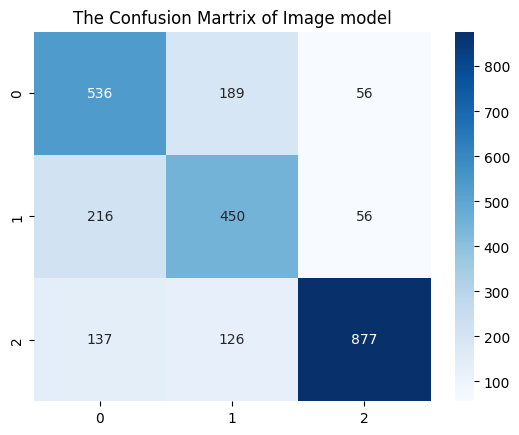

In [31]:


test_loss, test_acc, predictions, true_labels = test(model, test_loader, criterion, DEVICE)

print(f"Test Acc: {test_acc:.4f}")

true_labels = [dic[i] for i in true_labels]
predictions = [dic[i] for i in predictions]

print(classification_report(true_labels,predictions))
cm = confusion_matrix(true_labels,predictions)
p = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues" )
plt.title('The Confusion Martrix of Image model')